# **ETIVITY 4- CLASSIFICATION**

---



**Student Name :RIYA JOE**

**Student Id :20023693**

#**TASK1**

- Import necessary packages and read the data into a pandas dataframe 

In [287]:
import pandas as pd
import numpy as np
data=pd.read_csv("seeds.csv")
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
from sklearn import manifold 
from sklearn import cluster 
from sklearn.cluster import KMeans
from sklearn import preprocessing 
from sklearn import metrics
%matplotlib inline
data

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


- Check for Null values in the data set 

In [288]:
data.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

- Perform numerical analysis of the data set 

In [289]:
data.describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


# Binary Classification Conversion

- The Sample data has 3 classes of seeds and hence it a multi class problem , the scope of the ectivity is to transform our multiclass data into a Binary classificaton problem 

In [290]:
data['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

Lets try to map the values into 2 classes 0,1 based on K-Means Clustering 

Function to plot the cluster variation 

In [291]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)
    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

Invoke clustering_scatterplot () , pass the paramters for plotting the graph 

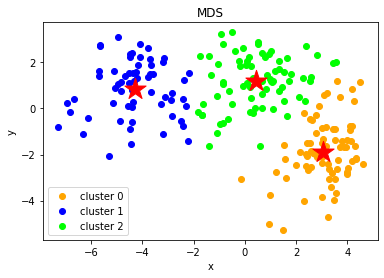

In [292]:
clustering_scatterplot(points=XYcoordinates_MDS_k3[:-3,:], 
                       labels=data_cluster_3.labels_, 
                       centers=XYcoordinates_MDS_k3[-3:,:], 
                       title='MDS')

From graph we see that 
1. cluster 0 =Type 1
2. cluster 1 =Type 2
3. cluster 2 =Type 3 

So Grouping 2 and 3 Together as 0 and 1 as a standalone type 





In [293]:
mapper = {2: 0, 3: 0}
data['type'] = data['type'].replace(mapper)
data['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

# Identify outliers in various data parameters 

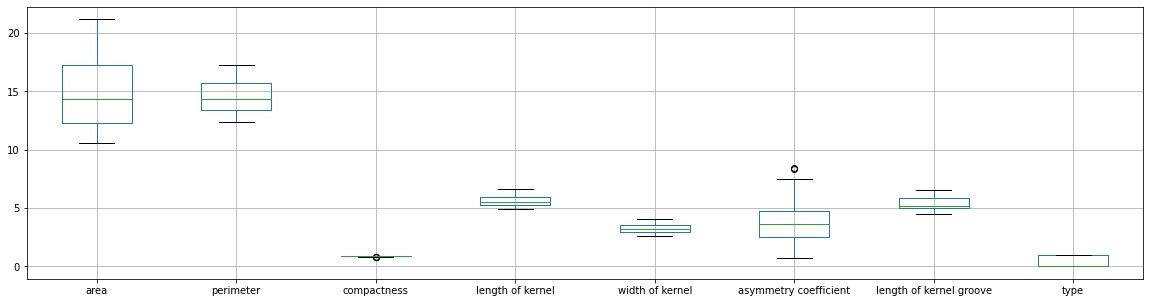

In [294]:
data.boxplot(figsize=(20,5))
plt.show()

- Asymmetry coefficient,compactness have  outliers present in them , so using a robust scaler would help us resolve the issue 

- Robust scalar for Column asymmetry coefficient 

In [295]:
# store a list with the names of all predictors
names_all = [c for c in data if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient','compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

- Function for Transformation and pipelining

In [296]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [297]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

- Pipelines constructed for scaling , for performing parallel execution

In [298]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

- Split date into test and train data set for classification , using train=80% and test 20% which is the best ratio

In [299]:
y = data['type']
X = data.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

#**TASK2**

**Classifiers used are Support Vector Machine , Naive Bayes, Random Forest, KNN, Logistic Regression, MLP** 

AIM : TO PICK BEST CLASSIFER AND COMPARE IT WITH SVM AND RF

---



**1.Estimate best fit model using using SVM**

In [300]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__degree':[2,3,4],
    'svm__cache_size':[1500]}
    #'svm_max_iter'[]}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
SVC=search.best_score_
#print("Best estimators after hyper parameter tuning:",search.best_estimator_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_
search_predictions = search.predict(X_test)
print("******CLASSIFICATION REPORT*******")
print(classification_report(y_test, search_predictions))

Best CV score = 0.959:
Best parameters:  {'svm__C': 100, 'svm__cache_size': 1500, 'svm__degree': 2, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
******CLASSIFICATION REPORT*******
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        28
           1       0.92      0.86      0.89        14

    accuracy                           0.93        42
   macro avg       0.93      0.91      0.92        42
weighted avg       0.93      0.93      0.93        42



**2.Estimate Best Fit Model using Naive-Bayes GaussianNB**

In [301]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('nb', GaussianNB())])
param_grid = {
    #'nb__priors':['None'],
    'nb__var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
NB=search.best_score_
# store the best params and best model for later use
NB_best_params = search.best_params_
NB_best_model = search.best_estimator_
search_predictions = search.predict(X_test)
print("******CLASSIFICATION REPORT*******")
print(classification_report(y_test, search_predictions))

Best CV score = 0.899:
Best parameters:  {'nb__var_smoothing': 0.01}
******CLASSIFICATION REPORT*******
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.79      0.79      0.79        14

    accuracy                           0.86        42
   macro avg       0.84      0.84      0.84        42
weighted avg       0.86      0.86      0.86        42



**3.Estimate Best Fit Model using K-Nearest Neighbours**

In [302]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])
param_grid = {
    'knn__n_neighbors': [3,5,7,11,19],
    'knn__weights': ['distance','uniform'],
    'knn__metric':['euclidean','manhattan']
  
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
KNN=search.best_score_
# store the best params and best model for later use
knn_best_params = search.best_params_
knn_best_model = search.best_estimator_
search_predictions = search.predict(X_test)
print("******CLASSIFICATION REPORT*******")
print(classification_report(y_test, search_predictions))

Best CV score = 0.941:
Best parameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
******CLASSIFICATION REPORT*******
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        28
           1       0.92      0.86      0.89        14

    accuracy                           0.93        42
   macro avg       0.93      0.91      0.92        42
weighted avg       0.93      0.93      0.93        42



**4.Estimate best fit model using Random Forest Classification**

In [303]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__criterion': ['gini', 'entropy']
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
RF=search.best_score_
# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_
search_predictions = search.predict(X_test)
print("******CLASSIFICATION REPORT*******")
print(classification_report(y_test, search_predictions))

Best CV score = 0.935:
Best parameters:  {'rf__criterion': 'entropy', 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__n_estimators': 30}
******CLASSIFICATION REPORT*******
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.79      0.79      0.79        14

    accuracy                           0.86        42
   macro avg       0.84      0.84      0.84        42
weighted avg       0.86      0.86      0.86        42



**5.Estimate best fit model using MLP Classifier**

In [304]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier(max_iter=100))])

pipe = MLPClassifier(max_iter=100)

param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)
MLP=search.best_score_
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
search_predictions = search.predict(X_test)
print("******CLASSIFICATION REPORT*******")
print(classification_report(y_test, search_predictions))



Best CV score = 0.929:
Best parameters:  {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
******CLASSIFICATION REPORT*******
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.93      0.93      0.93        14

    accuracy                           0.95        42
   macro avg       0.95      0.95      0.95        42
weighted avg       0.95      0.95      0.95        42



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**5.Estimate best fit model using LogisticRegression**

In [305]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('log', LogisticRegression())])
param_grid = {
    'log__C': np.logspace(-3,3,7),
    'log__penalty': ['l1','l2'],
    'log__C': [1.0, 0.5],
    'log__solver': ['liblinear']
}


search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
LP=search.best_score_
# store the best params and best model for later use
log_best_params = search.best_params_
log_best_model = search.best_estimator_
search_predictions = search.predict(X_test)
print("******CLASSIFICATION REPORT*******")
print(classification_report(y_test, search_predictions))

Best CV score = 0.923:
Best parameters:  {'log__C': 1.0, 'log__penalty': 'l2', 'log__solver': 'liblinear'}
******CLASSIFICATION REPORT*******
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.79      0.79      0.79        14

    accuracy                           0.86        42
   macro avg       0.84      0.84      0.84        42
weighted avg       0.86      0.86      0.86        42



- Set False-Positive Rate 

In [306]:
test=[['SVM', SVC], ['KNN', KNN], ['Random Forest', RF],['MLP',MLP],['Logistic Regression',LP],['Naive Bayes',NB]]
df = pd.DataFrame(test, columns = ['Classifiers', 'Accuracy']) 
df

,Classifiers,Accuracy
0,SVM,0.958824
1,KNN,0.940809
2,Random Forest,0.934926
3,MLP,0.929044
4,Logistic Regression,0.923162
5,Naive Bayes,0.898897


In [307]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

- Function for accuracy, precison , recall , F1 score , auc , fpr are calculated for each model 

In [308]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
  
    _probabilities = model.predict_proba(X_test)[:,1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values,labels=[0])
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc
    #return _precision[0]

# Store  Parameters and Obtain Result Evaluate Model function 

In [309]:
RF_accuracy,RF_precision,RF_recall,RF_f1_score,RF_tpr,RF_auc = evaluate_model(X_test, y_test, RF_best_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


In [310]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


In [282]:
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


#**COMPARISON BETWEEN SVM AND RANDOM FOREST**

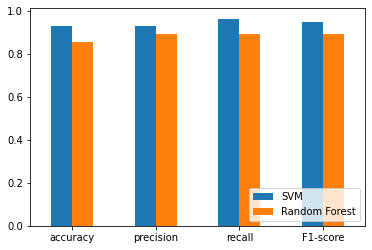

In [311]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Conclusion from comparison of two models 
  
1 .SVM is better than Random Forest classifier as for our seeds data it gives good accuracy , precision , recall and overall good F1 score 

# Plot comparison and ROC curve based on parameters for all classifiers 

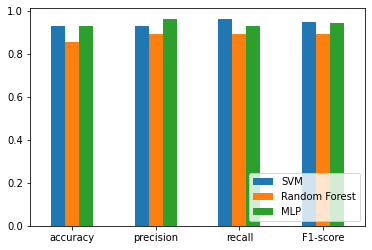

In [319]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics=np.array([MLP_accuracy,MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'MLP':MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

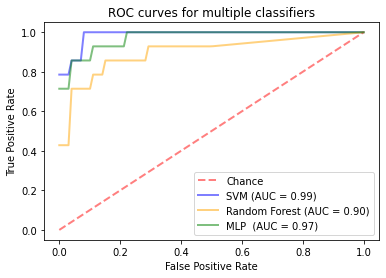

In [285]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.5)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.5)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.5)
plt.plot(mean_fpr, LP_tpr[0,:], lw=2, color='green', label='MLP  (AUC = %0.2f)' % (MLP_auc), alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

ROC curve shows that SVM and MLP covers more area under curve(AUC) than Random forest . Hence we can ignore random forest .Out of SVM and MLP , SVM covers more area than MLP , Hence our best classifier would be SVM followed by MLP. Having higher true positive rate than MLP .MLP has higher precision over SVM but nominal increase when considering other parameters over SVM.

#**TASK3**

Train Final Model and Save it

In [280]:
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [281]:
filename = 'model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# **SUMMARY**

I have chosen SVM to be an ideal classifier for this small data set . As it performs well throughout all iterations .Followed by third Classifier would be MLP.The model selection was not just based on Accuracy score alone , But verifying it with precison, recall,F1 as well. The seeds needs to identified correctly so precision and recall would go hand in hand , having higer F1 score would be desirable for our model.So both SVM and MLP shows Higher F1 Score Rate than rest of the classifiers like KNN , Naive Bayes . The grid parameters used for tuning of my SVM machine are :
Best CV score = 0.959:
Best parameters: 

1. C - Regularisation parameter chosen =100 
2. Gamma coeffient of rbf -0.01 
3. Kernal-The algorithm automatically uses the kernel function that is most appropriate to the data  -rbf
4. Degree -2 passed to support Poly kernal parameter 
5. Cache Size= memory used 1500
6. Max Iterations= Maximum number of iterations of the solver ,Not Used 



